# VAERepresentation - Training

In [27]:
import os, datetime
import numpy as np
import joblib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence

## Collect HTML files

Load the HTML files

In [2]:
files = []

for f in os.listdir(os.path.join(os.getcwd(),'html')):
    fd = open(os.path.join(os.getcwd(),'html',f),'r')
    content = fd.read()
    files.append(content)
    fd.close()

Add a mock file as a concatentation of a previous one

In [3]:
files.append(files[0]*10)

## Preprocess the files

Define the padding and trimming parameters

In [4]:
padding='post'

maxlen=200
truncating='post'

Load the tokenizer

In [5]:
SQLi_tokenizer = joblib.load('ignore_tokenizer_20210318105336141483')

Convert the pages into token sequences:

In [6]:
tokens_list = SQLi_tokenizer.texts_to_sequences(files)

Pad and trim the sequences to fit them into an array:

In [7]:
tokens_array = keras.preprocessing.sequence.pad_sequences(tokens_list, padding=padding, maxlen=maxlen, truncating=truncating)

## Defining VAE

Instantiating a VAE module built following [https://keras.io/examples/generative/vae/](https://keras.io/examples/generative/vae/).

*Sampling layer with reparametrization trick* $z_i\sim\mathcal{N}(\mu_\phi, \sigma_\phi)$

In [8]:
class Sampling(layers.Layer):
    
    def call(self,inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(.5 * z_log_var) * epsilon

*Encoder* $Q_\phi(z \vert x)$

In [9]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(200,))

x = layers.Dense(100,activation='relu')(encoder_inputs)
x = layers.Dense(25,activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean,z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean,z_log_var,z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          20100       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 25)           2525        dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            52          dense_1[0][0]                    
____________________________________________________________________________________________

*Decoder* $P_\theta(x\vert z)$

In [10]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(25,activation='relu')(latent_inputs)
x = layers.Dense(100,activation='relu')(x)
decoder_outputs = layers.Dense(200,activation='relu')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20200     
Total params: 22,875
Trainable params: 22,875
Non-trainable params: 0
_________________________________________________________________


*VAE with KL+reconstruction loss*

In [11]:
class VAE(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)           
            reconstruction = self.decoder(z)
            print(reconstruction)
            reconstruction_loss = keras.losses.mean_squared_error(data,reconstruction)
            #reconstruction_loss = tf.reduce_sum(keras.losses.mean_squared_error(data,reconstruction), axis=1)
            kl_loss = -.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = (tf.reduce_sum(kl_loss,axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

## Training the VAE

Instantiating and training the model

In [12]:
vae = VAE(encoder,decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(tokens_array, epochs=2000, batch_size=3)

Epoch 1/2000
Tensor("decoder/dense_4/Relu:0", shape=(None, 200), dtype=float32)
Tensor("decoder/dense_4/Relu:0", shape=(None, 200), dtype=float32)
2/2 [==============================] - 0s 25ms/step - loss: 131701112832.0000 - reconstruction_loss: 9842428.0000 - kl_loss: 107745615872.0000
Epoch 2/2000
2/2 [==============================] - 0s 5ms/step - loss: 533.6210 - reconstruction_loss: 278.3460 - kl_loss: 208.0049
Epoch 3/2000
2/2 [==============================] - 0s 13ms/step - loss: 557.5341 - reconstruction_loss: 276.8083 - kl_loss: 228.1437
Epoch 4/2000
2/2 [==============================] - 0s 7ms/step - loss: 557.7505 - reconstruction_loss: 275.4880 - kl_loss: 228.7308
Epoch 5/2000
2/2 [==============================] - 0s 5ms/step - loss: 552.9295 - reconstruction_loss: 273.9718 - kl_loss: 232.0421
Epoch 6/2000
2/2 [==============================] - 0s 8ms/step - loss: 554.7430 - reconstruction_loss: 272.5925 - kl_loss: 229.2576
Epoch 7/2000
2/2 [==========================

2/2 [==============================] - 0s 2ms/step - loss: 118.9661 - reconstruction_loss: 112.9112 - kl_loss: 20.7643
Epoch 122/2000
2/2 [==============================] - 0s 2ms/step - loss: 143.3183 - reconstruction_loss: 113.1844 - kl_loss: 19.6305
Epoch 123/2000
2/2 [==============================] - 0s 3ms/step - loss: 123.3341 - reconstruction_loss: 113.4987 - kl_loss: 21.0863
Epoch 124/2000
2/2 [==============================] - 0s 3ms/step - loss: 121.1612 - reconstruction_loss: 111.1416 - kl_loss: 19.7975
Epoch 125/2000
2/2 [==============================] - 0s 3ms/step - loss: 137.0278 - reconstruction_loss: 110.6582 - kl_loss: 20.3192
Epoch 126/2000
2/2 [==============================] - 0s 3ms/step - loss: 118.9794 - reconstruction_loss: 108.3490 - kl_loss: 20.3004
Epoch 127/2000
2/2 [==============================] - 0s 5ms/step - loss: 118.3451 - reconstruction_loss: 108.2872 - kl_loss: 19.9067
Epoch 128/2000
2/2 [==============================] - 0s 2ms/step - loss: 138

2/2 [==============================] - 0s 3ms/step - loss: 83.4639 - reconstruction_loss: 80.6495 - kl_loss: 11.3380
Epoch 243/2000
2/2 [==============================] - 0s 3ms/step - loss: 100.6274 - reconstruction_loss: 82.5415 - kl_loss: 12.4701
Epoch 244/2000
2/2 [==============================] - 0s 3ms/step - loss: 85.4057 - reconstruction_loss: 82.9772 - kl_loss: 12.4656
Epoch 245/2000
2/2 [==============================] - 0s 2ms/step - loss: 101.9392 - reconstruction_loss: 83.5404 - kl_loss: 12.3178
Epoch 246/2000
2/2 [==============================] - 0s 2ms/step - loss: 96.0690 - reconstruction_loss: 78.3968 - kl_loss: 11.8162
Epoch 247/2000
2/2 [==============================] - 0s 2ms/step - loss: 99.7650 - reconstruction_loss: 82.0310 - kl_loss: 11.7701
Epoch 248/2000
2/2 [==============================] - 0s 3ms/step - loss: 97.2955 - reconstruction_loss: 78.7913 - kl_loss: 12.9004
Epoch 249/2000
2/2 [==============================] - 0s 3ms/step - loss: 96.5355 - recon

2/2 [==============================] - 0s 4ms/step - loss: 95.6940 - reconstruction_loss: 78.9358 - kl_loss: 10.6045
Epoch 366/2000
2/2 [==============================] - 0s 3ms/step - loss: 94.6668 - reconstruction_loss: 76.4035 - kl_loss: 9.8605
Epoch 367/2000
2/2 [==============================] - 0s 3ms/step - loss: 76.6833 - reconstruction_loss: 75.8282 - kl_loss: 10.6118
Epoch 368/2000
2/2 [==============================] - 0s 2ms/step - loss: 91.2052 - reconstruction_loss: 71.9997 - kl_loss: 10.7863
Epoch 369/2000
2/2 [==============================] - 0s 2ms/step - loss: 72.1896 - reconstruction_loss: 72.4709 - kl_loss: 10.4193
Epoch 370/2000
2/2 [==============================] - 0s 4ms/step - loss: 91.7209 - reconstruction_loss: 74.8704 - kl_loss: 10.5736
Epoch 371/2000
2/2 [==============================] - 0s 2ms/step - loss: 71.9064 - reconstruction_loss: 72.1714 - kl_loss: 10.9802
Epoch 372/2000
2/2 [==============================] - 0s 3ms/step - loss: 74.0373 - reconstr

2/2 [==============================] - 0s 4ms/step - loss: 85.1649 - reconstruction_loss: 69.4094 - kl_loss: 7.6632
Epoch 490/2000
2/2 [==============================] - 0s 3ms/step - loss: 68.2905 - reconstruction_loss: 71.2497 - kl_loss: 8.2356
Epoch 491/2000
2/2 [==============================] - 0s 5ms/step - loss: 71.8159 - reconstruction_loss: 72.0369 - kl_loss: 7.6139
Epoch 492/2000
2/2 [==============================] - 0s 4ms/step - loss: 68.7850 - reconstruction_loss: 73.6382 - kl_loss: 7.3626
Epoch 493/2000
2/2 [==============================] - 0s 3ms/step - loss: 84.3295 - reconstruction_loss: 69.0745 - kl_loss: 7.6756
Epoch 494/2000
2/2 [==============================] - 0s 4ms/step - loss: 69.5527 - reconstruction_loss: 72.1899 - kl_loss: 8.1369
Epoch 495/2000
2/2 [==============================] - 0s 5ms/step - loss: 67.8525 - reconstruction_loss: 70.1856 - kl_loss: 8.7895
Epoch 496/2000
2/2 [==============================] - 0s 4ms/step - loss: 88.5717 - reconstruction

2/2 [==============================] - 0s 3ms/step - loss: 87.3766 - reconstruction_loss: 72.2553 - kl_loss: 8.4341
Epoch 613/2000
2/2 [==============================] - 0s 3ms/step - loss: 85.3008 - reconstruction_loss: 70.9551 - kl_loss: 8.1683
Epoch 614/2000
2/2 [==============================] - 0s 2ms/step - loss: 82.9709 - reconstruction_loss: 69.2968 - kl_loss: 7.7135
Epoch 615/2000
2/2 [==============================] - 0s 4ms/step - loss: 88.4221 - reconstruction_loss: 73.8455 - kl_loss: 7.9780
Epoch 616/2000
2/2 [==============================] - 0s 6ms/step - loss: 68.2532 - reconstruction_loss: 68.7626 - kl_loss: 7.7399
Epoch 617/2000
2/2 [==============================] - 0s 7ms/step - loss: 69.3671 - reconstruction_loss: 70.0186 - kl_loss: 8.0451
Epoch 618/2000
2/2 [==============================] - 0s 4ms/step - loss: 87.1213 - reconstruction_loss: 69.7873 - kl_loss: 8.2781
Epoch 619/2000
2/2 [==============================] - 0s 5ms/step - loss: 84.3261 - reconstruction

2/2 [==============================] - 0s 3ms/step - loss: 84.0978 - reconstruction_loss: 69.7215 - kl_loss: 6.3410
Epoch 737/2000
2/2 [==============================] - 0s 3ms/step - loss: 66.5430 - reconstruction_loss: 68.0484 - kl_loss: 6.4822
Epoch 738/2000
2/2 [==============================] - 0s 3ms/step - loss: 79.8250 - reconstruction_loss: 68.5608 - kl_loss: 5.8464
Epoch 739/2000
2/2 [==============================] - 0s 4ms/step - loss: 65.7346 - reconstruction_loss: 68.0818 - kl_loss: 5.9151
Epoch 740/2000
2/2 [==============================] - 0s 3ms/step - loss: 83.2576 - reconstruction_loss: 71.5947 - kl_loss: 5.9425
Epoch 741/2000
2/2 [==============================] - 0s 4ms/step - loss: 80.1429 - reconstruction_loss: 68.9478 - kl_loss: 5.9078
Epoch 742/2000
2/2 [==============================] - 0s 6ms/step - loss: 65.7903 - reconstruction_loss: 70.3207 - kl_loss: 5.6710
Epoch 743/2000
2/2 [==============================] - 0s 6ms/step - loss: 63.9371 - reconstruction

2/2 [==============================] - 0s 7ms/step - loss: 84.6836 - reconstruction_loss: 63.1204 - kl_loss: 12.1729
Epoch 861/2000
2/2 [==============================] - 0s 5ms/step - loss: 62.9495 - reconstruction_loss: 62.9307 - kl_loss: 12.2509
Epoch 862/2000
2/2 [==============================] - 0s 6ms/step - loss: 83.7649 - reconstruction_loss: 64.7926 - kl_loss: 12.0661
Epoch 863/2000
2/2 [==============================] - 0s 4ms/step - loss: 63.6147 - reconstruction_loss: 63.4218 - kl_loss: 12.2917
Epoch 864/2000
2/2 [==============================] - 0s 3ms/step - loss: 83.1395 - reconstruction_loss: 62.0149 - kl_loss: 12.4259
Epoch 865/2000
2/2 [==============================] - 0s 3ms/step - loss: 62.7248 - reconstruction_loss: 62.4311 - kl_loss: 12.3002
Epoch 866/2000
2/2 [==============================] - 0s 3ms/step - loss: 84.1695 - reconstruction_loss: 63.0593 - kl_loss: 12.0073
Epoch 867/2000
2/2 [==============================] - 0s 3ms/step - loss: 80.9581 - reconst

2/2 [==============================] - 0s 3ms/step - loss: 78.7072 - reconstruction_loss: 63.1248 - kl_loss: 8.5706
Epoch 985/2000
2/2 [==============================] - 0s 2ms/step - loss: 61.2804 - reconstruction_loss: 65.9930 - kl_loss: 7.8944
Epoch 986/2000
2/2 [==============================] - 0s 4ms/step - loss: 77.0947 - reconstruction_loss: 60.6106 - kl_loss: 8.1088
Epoch 987/2000
2/2 [==============================] - 0s 2ms/step - loss: 87.5512 - reconstruction_loss: 67.9405 - kl_loss: 9.2440
Epoch 988/2000
2/2 [==============================] - 0s 3ms/step - loss: 75.2213 - reconstruction_loss: 60.2581 - kl_loss: 8.8737
Epoch 989/2000
2/2 [==============================] - 0s 2ms/step - loss: 67.8865 - reconstruction_loss: 75.7035 - kl_loss: 8.1211
Epoch 990/2000
2/2 [==============================] - 0s 2ms/step - loss: 77.6520 - reconstruction_loss: 61.4708 - kl_loss: 7.7355
Epoch 991/2000
2/2 [==============================] - 0s 4ms/step - loss: 116.3445 - reconstructio

2/2 [==============================] - 0s 3ms/step - loss: 72.1363 - reconstruction_loss: 59.3894 - kl_loss: 8.2841
Epoch 1107/2000
2/2 [==============================] - 0s 3ms/step - loss: 72.9872 - reconstruction_loss: 55.4939 - kl_loss: 8.7926
Epoch 1108/2000
2/2 [==============================] - 0s 3ms/step - loss: 69.3338 - reconstruction_loss: 53.1004 - kl_loss: 9.3216
Epoch 1109/2000
2/2 [==============================] - 0s 4ms/step - loss: 49.8410 - reconstruction_loss: 53.8777 - kl_loss: 9.7213
Epoch 1110/2000
2/2 [==============================] - 0s 3ms/step - loss: 49.7940 - reconstruction_loss: 53.8107 - kl_loss: 9.8762
Epoch 1111/2000
2/2 [==============================] - 0s 4ms/step - loss: 69.4445 - reconstruction_loss: 54.3162 - kl_loss: 9.6857
Epoch 1112/2000
2/2 [==============================] - 0s 3ms/step - loss: 69.3830 - reconstruction_loss: 53.1734 - kl_loss: 9.4230
Epoch 1113/2000
2/2 [==============================] - 0s 3ms/step - loss: 49.1518 - reconst

2/2 [==============================] - 0s 5ms/step - loss: 44.1253 - reconstruction_loss: 49.2235 - kl_loss: 6.7060
Epoch 1229/2000
2/2 [==============================] - 0s 3ms/step - loss: 61.3001 - reconstruction_loss: 47.8389 - kl_loss: 6.7415
Epoch 1230/2000
2/2 [==============================] - 0s 3ms/step - loss: 63.9274 - reconstruction_loss: 47.4716 - kl_loss: 7.1200
Epoch 1231/2000
2/2 [==============================] - 0s 4ms/step - loss: 44.7350 - reconstruction_loss: 48.7362 - kl_loss: 7.2105
Epoch 1232/2000
2/2 [==============================] - 0s 3ms/step - loss: 64.9186 - reconstruction_loss: 48.5147 - kl_loss: 7.3263
Epoch 1233/2000
2/2 [==============================] - 0s 5ms/step - loss: 62.1300 - reconstruction_loss: 48.6374 - kl_loss: 7.3530
Epoch 1234/2000
2/2 [==============================] - 0s 3ms/step - loss: 45.1921 - reconstruction_loss: 48.4228 - kl_loss: 7.3079
Epoch 1235/2000
2/2 [==============================] - 0s 3ms/step - loss: 63.2433 - reconst

2/2 [==============================] - 0s 5ms/step - loss: 62.1923 - reconstruction_loss: 46.1364 - kl_loss: 6.5953
Epoch 1352/2000
2/2 [==============================] - 0s 3ms/step - loss: 64.1417 - reconstruction_loss: 48.1371 - kl_loss: 6.9294
Epoch 1353/2000
2/2 [==============================] - 0s 6ms/step - loss: 61.4037 - reconstruction_loss: 45.8656 - kl_loss: 6.8109
Epoch 1354/2000
2/2 [==============================] - 0s 3ms/step - loss: 58.1838 - reconstruction_loss: 45.7280 - kl_loss: 6.7811
Epoch 1355/2000
2/2 [==============================] - 0s 8ms/step - loss: 65.6700 - reconstruction_loss: 49.4610 - kl_loss: 6.6730
Epoch 1356/2000
2/2 [==============================] - 0s 3ms/step - loss: 40.0131 - reconstruction_loss: 46.4408 - kl_loss: 6.8481
Epoch 1357/2000
2/2 [==============================] - 0s 6ms/step - loss: 39.0841 - reconstruction_loss: 45.3372 - kl_loss: 7.0447
Epoch 1358/2000
2/2 [==============================] - 0s 3ms/step - loss: 59.7467 - reconst

Epoch 1475/2000
2/2 [==============================] - 0s 4ms/step - loss: 41.9397 - reconstruction_loss: 48.2990 - kl_loss: 7.8497
Epoch 1476/2000
2/2 [==============================] - 0s 5ms/step - loss: 60.3515 - reconstruction_loss: 45.4452 - kl_loss: 8.0217
Epoch 1477/2000
2/2 [==============================] - 0s 2ms/step - loss: 65.3384 - reconstruction_loss: 47.4481 - kl_loss: 7.8956
Epoch 1478/2000
2/2 [==============================] - 0s 5ms/step - loss: 63.1918 - reconstruction_loss: 45.7641 - kl_loss: 7.8514
Epoch 1479/2000
2/2 [==============================] - 0s 3ms/step - loss: 61.5235 - reconstruction_loss: 46.5638 - kl_loss: 8.0609
Epoch 1480/2000
2/2 [==============================] - 0s 2ms/step - loss: 61.2077 - reconstruction_loss: 46.2172 - kl_loss: 8.0262
Epoch 1481/2000
2/2 [==============================] - 0s 2ms/step - loss: 59.5333 - reconstruction_loss: 45.3302 - kl_loss: 8.0638
Epoch 1482/2000
2/2 [==============================] - 0s 4ms/step - loss: 4

2/2 [==============================] - 0s 4ms/step - loss: 62.7996 - reconstruction_loss: 46.6637 - kl_loss: 7.1387
Epoch 1598/2000
2/2 [==============================] - 0s 3ms/step - loss: 62.6120 - reconstruction_loss: 46.4482 - kl_loss: 7.1074
Epoch 1599/2000
2/2 [==============================] - 0s 4ms/step - loss: 60.2176 - reconstruction_loss: 44.6049 - kl_loss: 6.9268
Epoch 1600/2000
2/2 [==============================] - 0s 3ms/step - loss: 61.9374 - reconstruction_loss: 45.8188 - kl_loss: 6.8069
Epoch 1601/2000
2/2 [==============================] - 0s 9ms/step - loss: 41.1565 - reconstruction_loss: 45.1116 - kl_loss: 6.5062
Epoch 1602/2000
2/2 [==============================] - 0s 3ms/step - loss: 41.0150 - reconstruction_loss: 45.4492 - kl_loss: 6.4892
Epoch 1603/2000
2/2 [==============================] - 0s 3ms/step - loss: 59.5932 - reconstruction_loss: 46.4632 - kl_loss: 6.3033
Epoch 1604/2000
2/2 [==============================] - 0s 3ms/step - loss: 59.0249 - reconst

2/2 [==============================] - 0s 4ms/step - loss: 62.4725 - reconstruction_loss: 47.5919 - kl_loss: 6.2489
Epoch 1659/2000
2/2 [==============================] - 0s 3ms/step - loss: 58.1435 - reconstruction_loss: 45.8706 - kl_loss: 6.3085
Epoch 1660/2000
2/2 [==============================] - 0s 3ms/step - loss: 60.4878 - reconstruction_loss: 45.2574 - kl_loss: 6.7747
Epoch 1661/2000
2/2 [==============================] - 0s 6ms/step - loss: 59.7919 - reconstruction_loss: 46.4476 - kl_loss: 6.9935
Epoch 1662/2000
2/2 [==============================] - 0s 8ms/step - loss: 57.3398 - reconstruction_loss: 44.5846 - kl_loss: 6.9658
Epoch 1663/2000
2/2 [==============================] - 0s 5ms/step - loss: 40.8397 - reconstruction_loss: 44.5959 - kl_loss: 6.6871
Epoch 1664/2000
2/2 [==============================] - 0s 8ms/step - loss: 59.2402 - reconstruction_loss: 47.0923 - kl_loss: 6.4961
Epoch 1665/2000
2/2 [==============================] - 0s 5ms/step - loss: 61.1547 - reconst

2/2 [==============================] - 0s 2ms/step - loss: 56.9376 - reconstruction_loss: 44.6225 - kl_loss: 5.8577
Epoch 1783/2000
2/2 [==============================] - 0s 2ms/step - loss: 58.0686 - reconstruction_loss: 46.0835 - kl_loss: 5.7061
Epoch 1784/2000
2/2 [==============================] - 0s 2ms/step - loss: 41.2517 - reconstruction_loss: 46.0986 - kl_loss: 5.9105
Epoch 1785/2000
2/2 [==============================] - 0s 2ms/step - loss: 38.4535 - reconstruction_loss: 46.3524 - kl_loss: 5.9172
Epoch 1786/2000
2/2 [==============================] - 0s 2ms/step - loss: 38.1883 - reconstruction_loss: 46.1828 - kl_loss: 5.8986
Epoch 1787/2000
2/2 [==============================] - 0s 3ms/step - loss: 41.4274 - reconstruction_loss: 46.5045 - kl_loss: 6.1330
Epoch 1788/2000
2/2 [==============================] - 0s 3ms/step - loss: 38.7503 - reconstruction_loss: 45.8638 - kl_loss: 6.1792
Epoch 1789/2000
2/2 [==============================] - 0s 3ms/step - loss: 63.7493 - reconst

2/2 [==============================] - 0s 2ms/step - loss: 40.6900 - reconstruction_loss: 45.0518 - kl_loss: 6.1413
Epoch 1906/2000
2/2 [==============================] - 0s 2ms/step - loss: 39.2679 - reconstruction_loss: 44.4556 - kl_loss: 6.1666
Epoch 1907/2000
2/2 [==============================] - 0s 2ms/step - loss: 41.7691 - reconstruction_loss: 46.5595 - kl_loss: 6.0852
Epoch 1908/2000
2/2 [==============================] - 0s 4ms/step - loss: 39.5164 - reconstruction_loss: 44.1538 - kl_loss: 5.7709
Epoch 1909/2000
2/2 [==============================] - 0s 2ms/step - loss: 56.6829 - reconstruction_loss: 46.1234 - kl_loss: 5.6296
Epoch 1910/2000
2/2 [==============================] - 0s 9ms/step - loss: 37.9454 - reconstruction_loss: 46.0654 - kl_loss: 5.5749
Epoch 1911/2000
2/2 [==============================] - 0s 4ms/step - loss: 58.7473 - reconstruction_loss: 44.6593 - kl_loss: 5.5386
Epoch 1912/2000
2/2 [==============================] - 0s 2ms/step - loss: 41.0436 - reconst

## Checking the VAE

Printing the encoding of the first three data points (showing $\mu_\phi, \log\sigma_\phi, z$)

In [13]:
vae.encoder(tokens_array[0:3])

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 1.6656849 , -0.16751406],
        [-2.3210595 ,  1.8313726 ],
        [-2.3174183 , -0.53072315]], dtype=float32)>,
 <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-2.2767618, -2.5296786],
        [-2.5896828, -3.2344272],
        [-3.1676157, -2.70854  ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 1.6147189 , -0.12308165],
        [-2.5807557 ,  1.6444936 ],
        [-1.906577  , -0.78468853]], dtype=float32)>]

Computing the encoding and decoding of the first datapoint

In [14]:
xtilde = vae.decoder(vae.encoder(tokens_array[0:1]))

Rounding the computed representation to integers

In [15]:
xtilde_int = np.round(xtilde)

Printing the original and the reconstructed representation.

In [16]:
len(tokens_array[0])

200

In [17]:
tokens_array[0]

array([13, 14, 15, 16, 47,  4,  5, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 48, 12, 49, 12, 30, 31,  4,  5, 10, 11, 32, 33,
        6, 34, 35, 36,  6, 37,  7,  1,  8,  9, 38,  2,  3, 39,  7,  1,  8,
        9, 40,  2,  3, 41,  1, 42,  2, 43,  3, 44, 45, 46,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [18]:
xtilde_int.shape

(1, 200)

In [19]:
xtilde_int

array([[12.,  0., 14., 15., 44.,  4.,  5., 10., 11., 16., 17., 18., 19.,
        20., 21., 22., 23., 24., 25., 26., 26., 27., 45., 13., 45., 11.,
        28., 27.,  4.,  0., 10., 11., 30., 31.,  9., 31., 32.,  0.,  6.,
        34.,  7.,  0., 10.,  8., 34.,  0.,  3., 32.,  7.,  0.,  8.,  0.,
        36.,  0.,  0., 38.,  0., 38.,  0., 41.,  0., 40.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [20]:
SQLi_tokenizer.sequences_to_texts(tokens_array[0:1])

['<!-- saved from url= 0042 http://jabba hackingarena no:806/index php --> <html><head><meta http-equiv= Content-Type content= text/html charset=UTF-8 ></head><body>Login as admin for the flag! <br>some content some content <form action= http://jabba hackingarena no:806/index php method= post > <table width= 100 > <tbody><tr><td>Name:</td> <td><input type= text name= username value= ></td></tr> <tr><td>Password:</td> <td><input type= text name= passwd value= ></td></tr> <tr><td><input type= submit value= Submit ></td></tr> </tbody></table> </form> </body></html>']

In [21]:
SQLi_tokenizer.sequences_to_texts(xtilde_int)

['content saved from </tbody></table> http://jabba hackingarena no:806/index php url= --> <html><head><meta http-equiv= Content-Type content= text/html charset=UTF-8 ></head><body>Login as admin admin for </form> <!-- </form> php the for http://jabba no:806/index php <form action= name= action= method= > <table <td><input no:806/index text <table ></td></tr> method= <td><input text 100 username username <tr><td><input passwd']

In [22]:
np.mean(xtilde_int==tokens_array[0])

0.74

## Saving the VAE

Saving the model weights

In [23]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S%f")
vae.save_weights('ignore_vae_W_'+timestamp)

Loading the model weights

In [24]:
vae1 = VAE(encoder,decoder)
vae1.load_weights('ignore_vae_W_'+timestamp)

Checking the weights

In [25]:
vae.decoder(vae.encoder(tokens_array[0:1])) == vae1.decoder(vae.encoder(tokens_array[0:1]))

<tf.Tensor: shape=(1, 200), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  

## Define a mock server

We import and instantiate a new server.

In [14]:
import SQLiServer
env = SQLiServer.mockSQLienv(files)

In [15]:
env.reset()

('\n<!-- saved from url=(0033)http://jabba.hackingarena.no:806/ -->\n<html><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"></head><body>Login as admin for the flag!\n\n<form action="http://jabba.hackingarena.no:806/index.php" method="post">\n<table width="100">\n<tbody><tr><td>Name:</td>\n<td><input type="text" name="username" value=""></td></tr>\n<tr><td>Password:</td>\n<td><input type="text" name="passwd" value=""></td></tr>\n\n<tr><td><input type="submit" value="Submit"></td></tr>\n</tbody></table>\n</form>\n\n</body></html>',
 0,
 False,
 'env reset')

## Running an agent

In [16]:
n_episodes = 1000

n_actions = 10
S0S1 = 2; S1S2 = 3

In [21]:
class Agent():
    
    def __init__(self,vae,n_actions,verbose=True):       
        self.n_actions = n_actions
        self.vae = vae
        
        self.state = np.array([0.,0.])
        self.Q = {self.state.tobytes(): np.ones(self.n_actions)} 
        
        self.total_trials = 0
        self.total_successes = 0
        
        self.verbose = verbose
             
    def set_learning_options(self,exploration=0.2,learningrate=0.1,discount=0.9,max_step=100):
        self.expl = exploration
        self.lr = learningrate
        self.discount = discount 
        self.max_step = max_step
        
    def _select_action(self):
        if (np.random.random() < self.expl):
            return np.random.randint(0,self.n_actions)        
        else:
            return np.argmax(self.Q[self.state.tobytes()])
        
    def step(self):
        self.steps = self.steps+1
        action = self._select_action()
        
        response,reward,termination,s = self.env.step(action)
        self.rewards = self.rewards + reward
        
        self._analyze_response(action,response,reward)
        self.terminated = termination
        if(self.verbose): print(s)
        
        return    
        
    
    def reset(self,env):
        self.env = env  
        self.terminated = False                     
        
        self.steps = 0
        self.rewards = 0
        
                
    def run_episode(self):
        _,_,self.terminated,s = self.env.reset()
        if(self.verbose): print(s)
        
        while not(self.terminated) and self.steps < self.max_step:
            self.step()
            #if(self.steps>500): self.terminated=True
            
        self.total_trials += 1
        if(self.terminated):
            self.total_successes += 1      
    
            
    def _analyze_response(self,action,response,reward):
        tokens = SQLi_tokenizer.texts_to_sequences([response])
        tokens = keras.preprocessing.sequence.pad_sequences(tokens, padding=padding, maxlen=maxlen, truncating=truncating)
        
        newstate = self.vae.encoder(tokens)[0].numpy()[0]       
        self._update_Q(self.state,newstate,action,reward)
        self.state = newstate
            
    def _update_Q(self,oldstate,newstate,action,reward):
        
        if(newstate.tobytes() in self.Q.keys()):
            best_action_newstate = np.argmax(self.Q[newstate.tobytes()])
        else:
            self.Q[newstate.tobytes()] = np.ones(self.n_actions)
            best_action_newstate = np.argmax(self.Q[newstate.tobytes()])
        
        self.Q[oldstate.tobytes()][action] = self.Q[oldstate.tobytes()][action] + self.lr * (reward + self.discount*self.Q[newstate.tobytes()][best_action_newstate] - self.Q[oldstate.tobytes()][action])

In [22]:
import SQLIiAgent
agent = SQLIiAgent.Agent(vae1,n_actions)

In [23]:
agent = Agent(vae1,n_actions)
agent.set_learning_options()

In [24]:
steps = []
rewards = []

for _ in range(n_episodes):
    
    env = SQLiServer.mockSQLienv(files,actions=n_actions,S0S1=S0S1,S1S2=S1S2,verbose=False)
    agent.reset(env)
    
    agent.run_episode()
    steps.append(agent.steps)
    rewards.append(agent.rewards)

env reset
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong re

correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wron

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong 

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wr

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request


wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
correct escape
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong reques

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
correct escape
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request


wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
env reset
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong 

wrong request
wrong request
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
flag
env reset
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wr

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
w

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
env reset
wrong request
wrong requ

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
w

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
flag
env reset
wrong request
wrong 

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wron

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wron

wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
wrong request
correct escape
flag
env reset
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wron

wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correc

correct escape
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct es

wrong request
correct escape
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
correct escape
wrong request
correct escape
wrong request
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correc

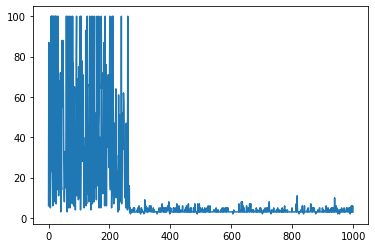

In [25]:
plt.plot(steps)